<a href="https://colab.research.google.com/github/tevrat-aksoy/YoloV4_Example/blob/main/YoloV4_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YoloV4  Example
===


## Install `tf2_yolov4` + TensorFlow

In [1]:
!pip install --no-cache-dir https://github.com/sicara/tf2-yolov4/archive/master.zip
!pip install tensorflow

     - 3.0MB 3.0MB/s
  Created wheel for tf2-yolov4: filename=tf2_yolov4-0.1.0-cp37-none-any.whl size=20143 sha256=0a07abe78d01702cd5b2f6e9d27fc8bbf37f23b4eacf247928311eef9f1740d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-rg47t4i3/wheels/dd/5a/79/53f47cadc4652a9a54ebe232fe724de8fdb8700e3a0c99bf9c
Successfully built tf2-yolov4


## Get COCO pretrained weights

First, download `yolov4.weights` from [AlexeyAB/darknet](https://github.com/AlexeyAB/darknet#how-to-evaluate-ap-of-yolov4-on-the-ms-coco-evaluation-server) repository.
The `yolov4.weights` file length should be `257717640`. If not, rerun the cell.

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT" -O yolov4.weights
!rm -rf /tmp/cookies.txt
!ls -la ./yolov4.weights

--2021-03-24 11:50:37--  https://docs.google.com/uc?export=download&confirm=X&id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT
Resolving docs.google.com (docs.google.com)... 108.177.11.100, 108.177.11.101, 108.177.11.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.11.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘yolov4.weights’

yolov4.weights          [ <=>                ]   3.21K  --.-KB/s    in 0s      

2021-03-24 11:50:38 (40.3 MB/s) - ‘yolov4.weights’ saved [3288]

-rw-r--r-- 1 root root 3288 Mar 24 11:50 ./yolov4.weights


`tf2_yolov4` provides a `convert-darknet-weights`, a script to convert a darknet weights file (*.weights) to a tensorflow weights file (*.h5):

In [3]:
!convert-darknet-weights yolov4.weights -o yolov4.h5
!ls -la ./yolov4.h5

2021-03-24 11:50:38.663076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-24 11:50:40.858152: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-24 11:50:40.859336: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-24 11:50:40.872697: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-24 11:50:40.872747: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2fcf29e74636): /proc/driver/nvidia/version does not exist
2021-03-24 11:50:40.873270: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-24 11:50:45.744797: I tensorflow/compiler/mlir/mlir_graph_optimizati

## Read an image file

Import tensorflow, tf2_yolov4 model and anchors

In [4]:
import tensorflow as tf

from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4
import cv2
import matplotlib.pyplot as plt
import os
import cv2
from pathlib import Path
from numpy import loadtxt
from keras.utils import get_file
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


Download an image:

--2021-03-24 11:50:51--  https://github.com/sicara/tf2-yolov4/raw/master/notebooks/images/cars.jpg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sicara/tf2-yolov4/master/notebooks/images/cars.jpg [following]
--2021-03-24 11:50:51--  https://raw.githubusercontent.com/sicara/tf2-yolov4/master/notebooks/images/cars.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197210 (193K) [image/jpeg]
Saving to: ‘cars.jpg.3’

cars.jpg.3          100%[===================>] 192.59K  --.-KB/s    in 0.03s   

2021-03-24 11:50:52 (6.98 MB/s) - ‘cars.jpg.3’ saved [197210/197210]



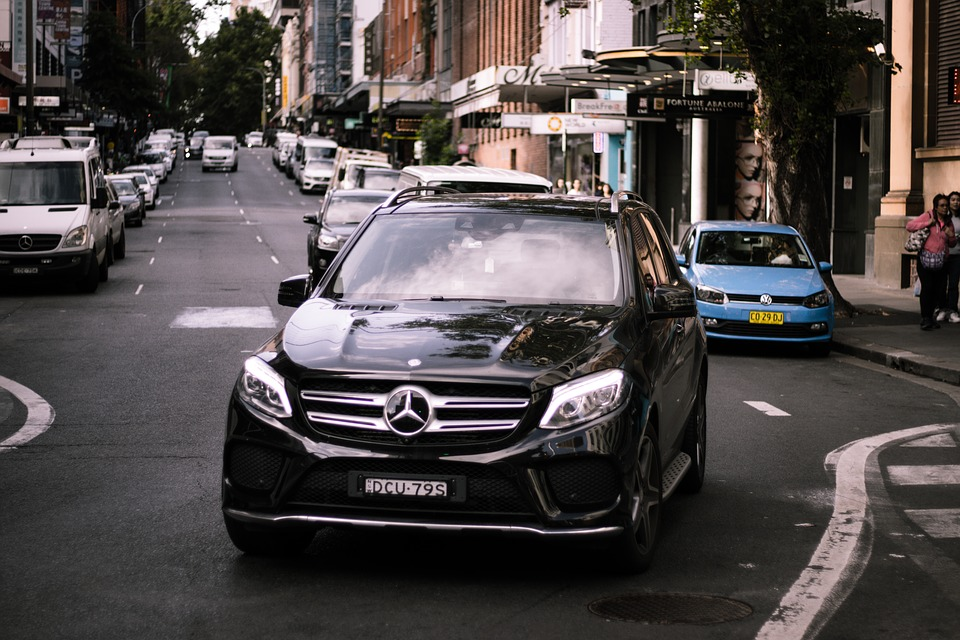

In [5]:
!wget https://github.com/sicara/tf2-yolov4/raw/master/notebooks/images/cars.jpg

from IPython.display import Image
Image('./cars.jpg')

In [6]:
# COCO classes
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = loadtxt("./colors.txt").tolist()  # box colors


 Define helper functions

In [7]:

def imShow(path):
  
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [8]:
def get_processed_image(img, boxes, scores, classes):
    """
        Draws the class boxes with their scores on a OpenCV image
        Arguments:
            img -- image opened with OpenCV
            boxes -- the list of boxes(their coordinates)
            scores -- the list of scores for each box
            classes -- the list of classes for each box
        Returns:
            img -- processed image with all the boxes drawn
    """
    for (xmin, ymin, xmax, ymax), score, cl in zip(boxes.tolist(), scores.tolist(), classes.tolist()):
        if score > 0:
            start_point = (int(xmin), int(ymin))
            end_point = (int(xmax), int(ymax))
            color=COLORS[cl % 6]
            img = cv2.rectangle(img, start_point, end_point, color, 2)  # draw class box
            text = f'{CLASSES[cl]}: {score:0.2f}'
            (test_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_ITALIC, 0.5, 1)
            end_point = (int(xmin) + test_width + 2, int(ymin) - text_height - 2)
            img = cv2.rectangle(img, start_point, end_point, color, -1)
            cv2.putText(img, text, start_point, cv2.FONT_ITALIC, 0.5, 0, 1)  # print class type with score
    return img

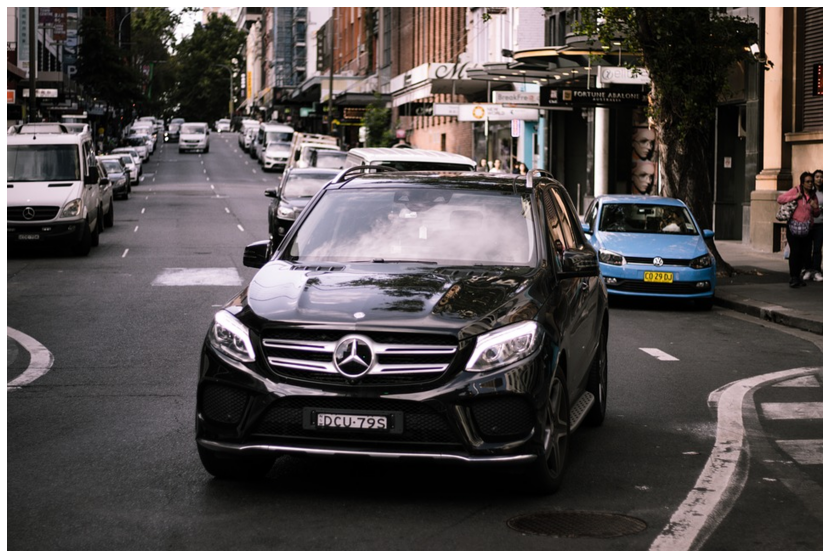

In [9]:
img = cv2.imread("/content/cars.jpg")
HEIGHT, WIDTH, _ = [length // 32 * 32 for length in img.shape]  # get image size
image = tf.convert_to_tensor(img)
image = tf.image.resize(image, (HEIGHT, WIDTH))
images = tf.expand_dims(image, axis=0) / 255.0
imShow("/content/cars.jpg")

# Creating Model

In [10]:
model = YOLOv4(
    input_shape=(HEIGHT, WIDTH, 3),
    anchors=YOLOV4_ANCHORS,
    num_classes=80,
    training=False,
    
    yolo_max_boxes=100,
    yolo_iou_threshold=0.5,
    yolo_score_threshold=0.5,
)

model.load_weights("./yolov4.h5")
model.summary()

Model: "YOLOv4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 640, 960, 3) 0                                            
__________________________________________________________________________________________________
CSPDarknet53 (Functional)       [(None, 80, 120, 256 26652512    input_8[0][0]                    
__________________________________________________________________________________________________
YOLOv4_neck (Functional)        [(None, 80, 120, 128 15857152    CSPDarknet53[0][0]               
                                                                 CSPDarknet53[0][1]               
                                                                 CSPDarknet53[0][2]               
_____________________________________________________________________________________________

In [11]:
boxes, scores, classes, valid_detections = model.predict(images)

In [12]:
if os.path.isdir("/content/output_image") is False:
        os.mkdir("/content/output_image")

output_image_path = os.path.join("/content/output_image", Path("/content/cars.jpg").name)

# Image Prediction

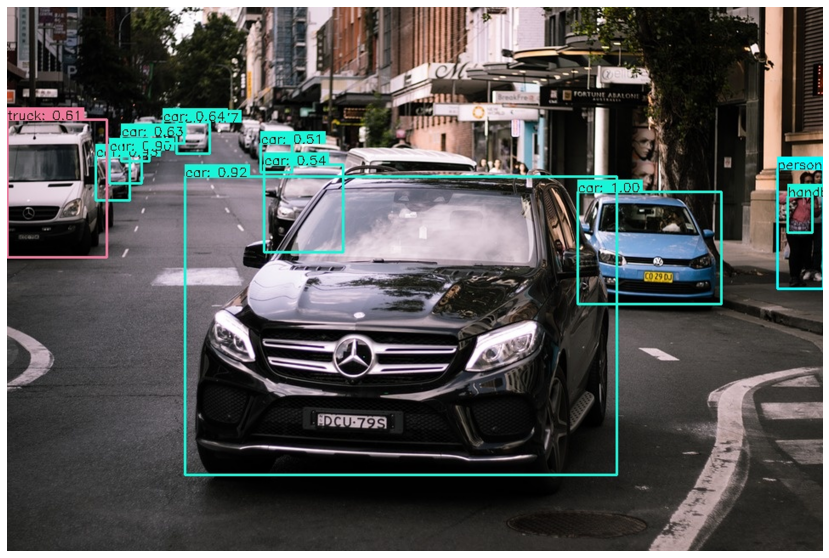

In [13]:
output_image=result_img = get_processed_image(img, boxes[0] * [WIDTH, HEIGHT, WIDTH, HEIGHT], scores[0], classes[0].astype(int))

cv2.imwrite(output_image_path, result_img)
imShow("/content/output_image/cars.jpg")

In [14]:
# Uploading a file
upload()

Saving test.mp4 to test (1).mp4
saved file test.mp4


Define video prediction function

In [15]:

def detect_video(video_path, output_path="output_videos"):
    """
        Detects the objects from a video using a YOLOv4 model and returns the result video with the same name
        Arguments:
            video_path -- path of the image to run detection on
            output_path -- the path of the output folder
        Returns:
            output_video_path -- path to processed video with all the boxes drawn
    """
    print("\nObject detection on " + Path(video_path).name)
    cap = cv2.VideoCapture(video_path)
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    WIDTH, HEIGHT = [length // 32 * 32 for length in frame_size]


    yolo_model = YOLOv4(input_shape=(HEIGHT, WIDTH, 3), anchors=YOLOV4_ANCHORS, num_classes=80,
                        training=False, yolo_max_boxes=100, yolo_iou_threshold=0.5, yolo_score_threshold=0.5,
                        )
   
    yolo_model.load_weights("./yolov4.h5")
    
    yolo_model.summary()
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    if os.path.isdir(output_path) is False:
        os.mkdir(output_path)
    output_video_path = os.path.join(output_path, Path(video_path).name)
    out = cv2.VideoWriter(output_video_path, fourcc, int(cap.get(cv2.CAP_PROP_FPS)), frame_size)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret is True:
            image = tf.convert_to_tensor(frame)
            image = tf.image.resize(image, (HEIGHT, WIDTH))
            images = tf.expand_dims(image, axis=0) / 255.0
            boxes, scores, classes, valid_detections = yolo_model.predict(images)

            frame = get_processed_image(frame, boxes[0] * [WIDTH, HEIGHT, WIDTH, HEIGHT], scores[0], classes[0].astype(int))
            #cv2_imshow(Path(video_path).name, frame)
            out.write(frame)
            if cv2.waitKey(int(50 // cap.get(cv2.CAP_PROP_FPS))) & 0xFF == 27:  # 27 = ESC ASCII code
                break
        else:
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return output_video_path



# Video Prediction

In [ ]:
detect_video("/content/test.mp4", "/content/output_videos")


Object detection on test.mp4
Model: "YOLOv4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 1056, 1920,  0                                            
__________________________________________________________________________________________________
CSPDarknet53 (Functional)       [(None, 132, 240, 25 26652512    input_24[0][0]                   
__________________________________________________________________________________________________
YOLOv4_neck (Functional)        [(None, 132, 240, 12 15857152    CSPDarknet53[0][0]               
                                                                 CSPDarknet53[0][1]               
                                                                 CSPDarknet53[0][2]               
_______________________________________________________________